## Load Libraries

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go


import warnings 
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 30)
color = sns.color_palette("Paired")
scale = 'coolwarm_r'

## Load Dataset

In [33]:
with open(r"data\cleaned\NYC TLC Trip Record - Clean.csv", "r") as file:
    clean_data = pd.read_csv(file)

In [34]:
df = clean_data.copy()
df.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,day_category,pickup_time,RatecodeID,PULocationID,PUBorough,PUZone,DOLocationID,DOBorough,DOZone,passenger_count,trip_distance,distance_bins,fare_amount,fare_amount_bins,tip_amount,tip_amount_bins,payment_type,trip_type,trip_duration,duration_bins,speed,speed_bins
0,2023-01-01 00:26:10,2023-01-01 00:37:11,Weekend,Midnight,Standard rate,166,Manhattan,Morningside Heights,143,Manhattan,Lincoln Square West,1.0,2.58,3-6 miles,14.9,<20$,4.03,1-5$,Credit card,Street-hail,11.02,11-20 minutes,14.05,11-20 mph
1,2023-01-01 00:51:03,2023-01-01 00:57:49,Weekend,Midnight,Standard rate,24,Manhattan,Bloomingdale,43,Manhattan,Central Park,1.0,1.81,<2 miles,10.7,<20$,2.64,1-5$,Credit card,Street-hail,6.77,<10 minutes,16.04,11-20 mph
2,2023-01-01 00:13:14,2023-01-01 00:19:03,Weekend,Midnight,Standard rate,41,Manhattan,Central Harlem,238,Manhattan,Upper West Side North,1.0,1.30,<2 miles,6.5,<20$,1.70,1-5$,Credit card,Street-hail,5.82,<10 minutes,13.40,11-20 mph
3,2023-01-01 00:33:04,2023-01-01 00:39:02,Weekend,Midnight,Standard rate,41,Manhattan,Central Harlem,74,Manhattan,East Harlem North,1.0,1.10,<2 miles,6.0,<20$,0.00,0$,Credit card,Street-hail,5.97,<10 minutes,11.06,11-20 mph
4,2023-01-01 00:53:31,2023-01-01 01:11:04,Weekend,Midnight,Standard rate,41,Manhattan,Central Harlem,262,Manhattan,Yorkville East,1.0,2.78,3-6 miles,17.7,<20$,0.00,0$,Cash,Street-hail,17.55,11-20 minutes,9.50,<10 mph


## Skimming

In [35]:
pd.DataFrame(
    {
        "feature": df.columns.values,
        "data_type": df.dtypes.values,
        "null_value(%)": df.isna().mean().values * 100,
        "neg_value(%)": [
            (
                len(df[col][df[col] < 0]) / len(df) * 100
                if col in df.select_dtypes(include=[np.number]).columns
                else 0
            )
            for col in df.columns
        ],
        "0_value(%)": [
            (
                len(df[col][df[col] == 0]) / len(df) * 100
                if col in df.select_dtypes(include=[np.number]).columns
                else 0
            )
            for col in df.columns
        ],
        "duplicate": df.duplicated().sum(),
        "n_unique": df.nunique().values,
        "sample_unique": [df[col].unique() for col in df.columns],
    }
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,n_unique,sample_unique
0,lpep_pickup_datetime,object,0.0,0.0,0.000,0,59508,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
1,lpep_dropoff_datetime,object,0.0,0.0,0.000,0,59493,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
2,day_category,object,0.0,0.0,0.000,0,2,"[Weekend, Weekdays]"
3,pickup_time,object,0.0,0.0,0.000,0,5,"[Midnight, Morning, Noon, Evening, Night]"
4,RatecodeID,object,0.0,0.0,0.000,0,4,"[Standard rate, Negotiated fare, JFK Airport, ..."
5,PULocationID,int64,0.0,0.0,0.000,0,192,"[166, 24, 41, 181, 255, 75, 66, 195, 83, 97, 7..."
6,PUBorough,object,0.0,0.0,0.000,0,5,"[Manhattan, Brooklyn, Queens, Bronx, Staten Is..."
7,PUZone,object,0.0,0.0,0.000,0,191,"[Morningside Heights, Bloomingdale, Central Ha..."
8,DOLocationID,int64,0.0,0.0,0.000,0,243,"[143, 43, 238, 74, 262, 45, 75, 166, 140, 234,..."
9,DOBorough,object,0.0,0.0,0.000,0,6,"[Manhattan, Brooklyn, Queens, Bronx, EWR, Stat..."


# Exploratory Data Analysis

## Categorical

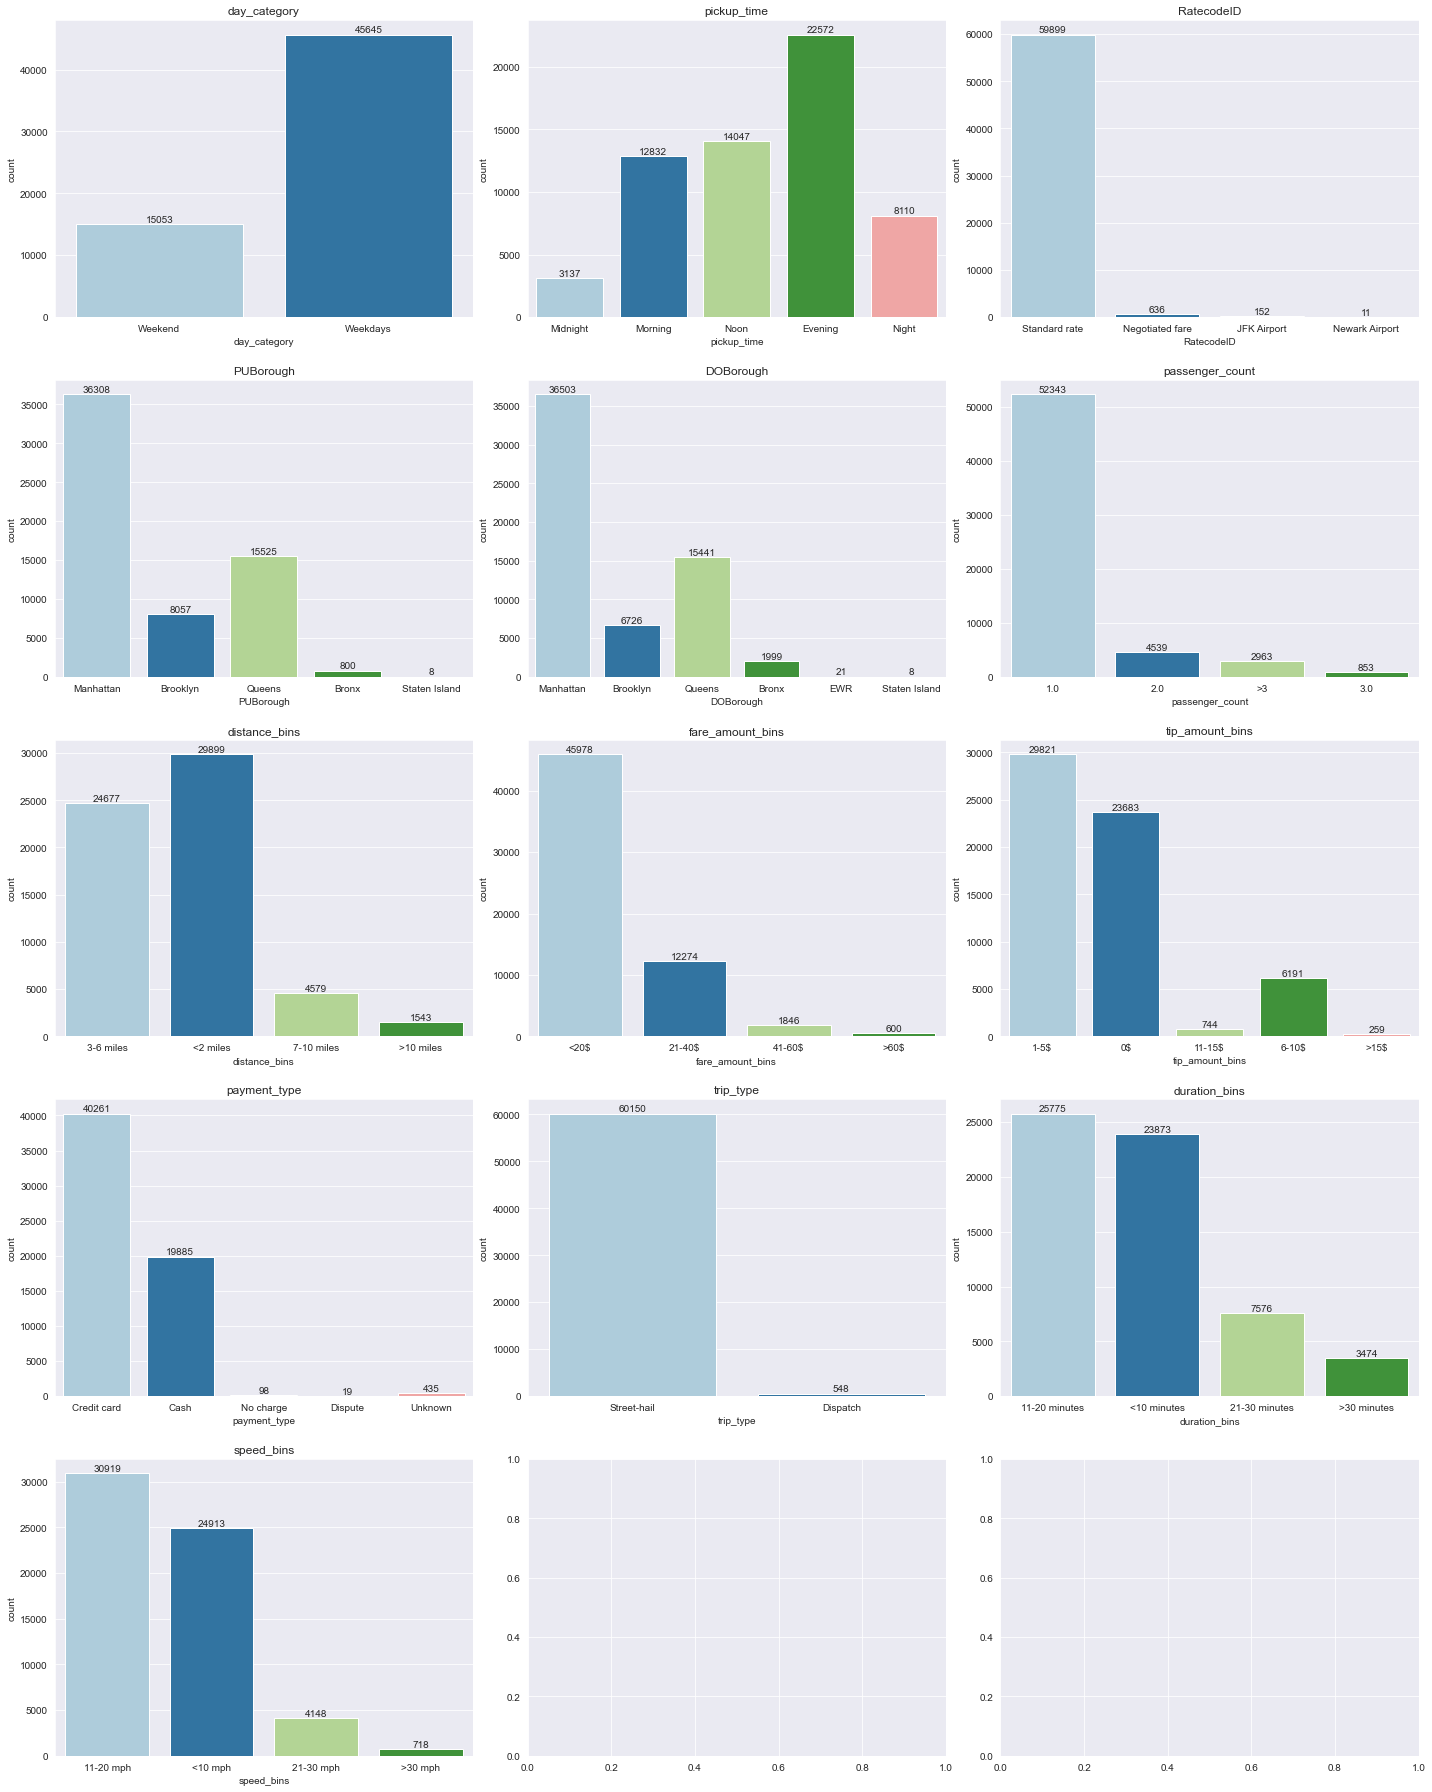

In [36]:
cols = [
    "day_category",
    "pickup_time",
    "RatecodeID",
    "PUBorough",
    "DOBorough",
    "passenger_count",
    "distance_bins",
    "fare_amount_bins",
    "tip_amount_bins",
    "payment_type",
    "trip_type",
    "duration_bins",
    "speed_bins",
]

fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(20, 25))
axs = axs.flatten()

for i, col in enumerate(cols):
    bars = sns.countplot(data=df, x=col, palette=color, ax=axs[i])
    axs[i].set_title(col)
    for idx, bar in enumerate(bars.patches):
        x_value = bar.get_x() + bar.get_width() / 2
        y_value = bar.get_height()
        label = "{:.0f}".format(bar.get_height())
        axs[i].text(x_value, y_value, label, ha="center", va="bottom")

plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()

## Numerical

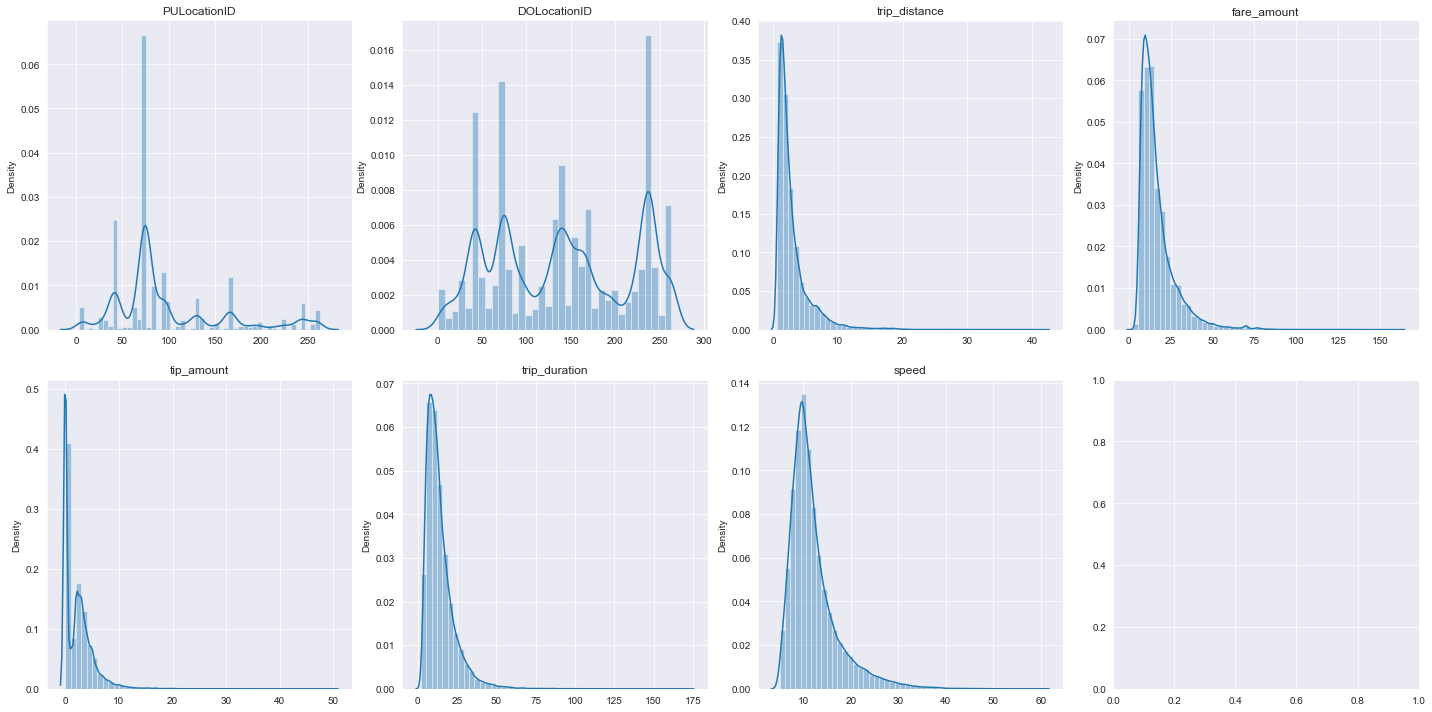

In [37]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k, v in df.select_dtypes(include=[np.number]).items():
    axs[index].set_title(k)
    sns.distplot(x=df[k], ax=axs[index])
    index += 1
plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()

**Insight**

- There is no normally distributed data.  
- In general, the data distribution tends to be right-skewed or positively skewed.

# Data Analysis

In [38]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

## Demand Based on Time

In [39]:
trip_monthly = df.groupby(df['lpep_pickup_datetime'].dt.date).agg(trip_bydate=('lpep_pickup_datetime', 'count')).reset_index()
trip_monthly['lpep_pickup_datetime'] = pd.to_datetime(trip_monthly['lpep_pickup_datetime'])
trip_monthly['day_of_week'] = trip_monthly['lpep_pickup_datetime'].dt.day_name()

trip_dayly = trip_monthly.groupby('day_of_week').agg(trip_byday=('trip_bydate', 'sum'), day_count=('day_of_week', 'count'), avg_trip=('trip_bydate', 'mean')).reset_index()
trip_dayly['day_cat']= trip_dayly['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

trip_dayly_cat = trip_dayly.groupby('day_cat').agg(trip_bycat=('trip_byday', 'sum')).reset_index()

trip_merge = pd.merge(trip_monthly, trip_dayly, on='day_of_week', how='left')
trip_merge = pd.merge(trip_merge, trip_dayly_cat, on='day_cat', how='left')

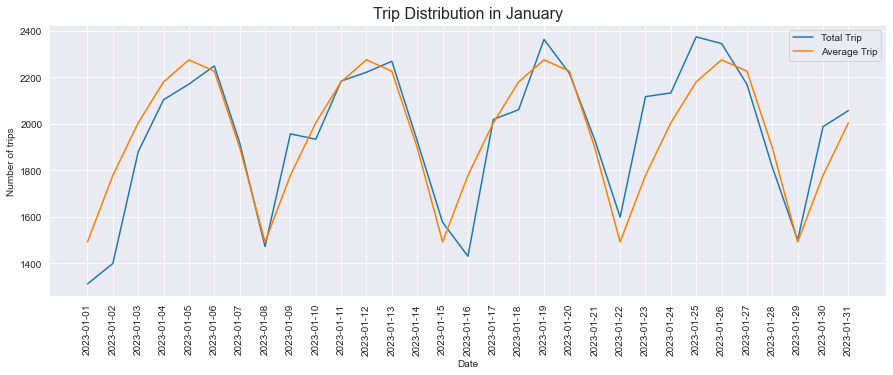

In [40]:
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')

sns.lineplot(data=trip_merge,
             x='lpep_pickup_datetime', 
             y='trip_bydate', 
             color=color[1],
             label = 'Total Trip')

sns.lineplot(data=trip_merge,
             x='lpep_pickup_datetime', 
             y='avg_trip',
             color=color[7],
             label = 'Average Trip')

plt.title('Trip Distribution in January', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.xticks(trip_monthly['lpep_pickup_datetime'], rotation=90)

plt.show()

**Insights**

- The highest number of taxi trips in January occurred on Wednesday, January 25, 2023.  
- Meanwhile, the lowest number of taxi trips in January occurred on Sunday, January 1, 2023.  
- There is a recurring pattern in the number of trips throughout January.

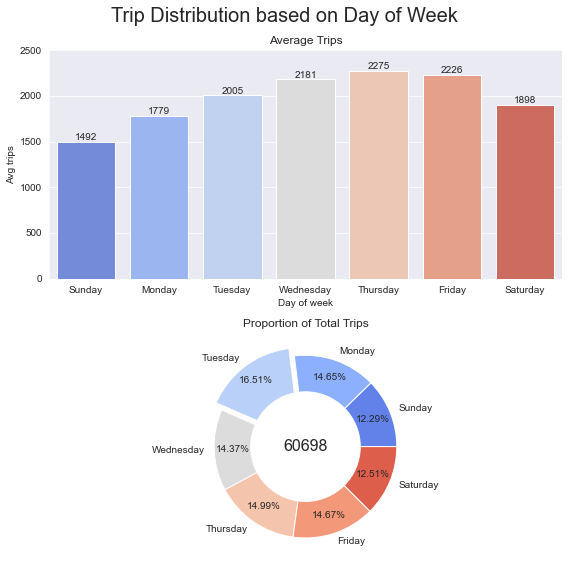

In [69]:
plt.figure(figsize=(8,8))

plt.suptitle('Trip Distribution based on Day of Week', fontsize=20)
plt.subplot(2,1,1)
bars = sns.barplot(x=trip_merge['day_of_week'].unique().tolist(), 
                   y=trip_merge['avg_trip'].unique().tolist(), 
                   palette=color)
for idx, bar in enumerate(bars.patches):
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 20
    label = "{:.0f}".format(trip_merge['avg_trip'].iloc[idx]) 
    plt.text(x_value, y_value, label, ha='center')

plt.title('Average Trips')
plt.xlabel('Day of week')
plt.ylabel('Avg trips')
plt.yticks(np.arange(0, 2501, 500))

plt.subplot(2,1,2)
plt.pie(x=trip_merge['trip_byday'].unique().tolist(), 
        labels=trip_merge['day_of_week'].unique().tolist(), 
        pctdistance=0.8, 
        autopct='%1.2f%%', 
        explode=(0,0,0.1,0,0,0,0), 
        colors=color)
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig.gca().add_artist(centre_circle)
plt.text(0, 0, trip_merge['trip_byday'].unique().sum(), ha='center', va='center', fontsize=16)
plt.title('Proportion of Total Trips')

plt.tight_layout()
plt.show()

**Insights**

- The highest proportion of total trips in January occurred on Wednesdays, accounting for 16% of the total trips.  
- However, based on the average number of trips per day, Thursdays had the highest daily trips, reaching 2,275 trips per day.  
- As weekdays approach, the number of trips consistently increases.  
- However, when the weekend arrives, the number of daily trips decreases significantly.  

In [42]:
day_order = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]
cross = pd.crosstab(
    index=df["lpep_pickup_datetime"].dt.day_name(),
    columns=df["lpep_pickup_datetime"].dt.hour,
    margins=True,
).reindex(day_order)
cross.columns.name = None
cross.index.name = "Day of Week"

melted_cross = (
    cross.iloc[:, :-1]
    .reset_index()
    .melt(id_vars="Day of Week", var_name="hour", value_name="trips")
)
cross

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,281,264,221,181,137,74,59,96,123,217,324,425,475,490,503,562,539,507,518,442,379,293,193,159,7462
Monday,110,67,49,62,52,51,134,375,418,482,484,508,525,565,580,695,704,704,724,552,378,305,218,151,8893
Tuesday,85,50,44,35,21,51,186,531,648,647,572,529,548,536,650,722,784,775,796,629,456,323,242,163,10023
Wednesday,84,66,27,25,17,43,165,406,510,518,504,452,430,470,535,651,689,747,733,601,408,279,211,152,8723
Thursday,88,61,41,25,31,51,163,424,505,544,508,496,466,498,589,658,699,760,793,543,444,309,240,165,9101
Friday,135,81,38,36,28,42,140,429,463,469,475,454,413,446,594,695,688,710,718,568,421,321,290,251,8905
Saturday,210,176,122,103,84,45,46,108,196,252,354,434,468,514,454,581,567,510,533,475,419,324,315,301,7591


Unique days: ['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday'] Count: 7


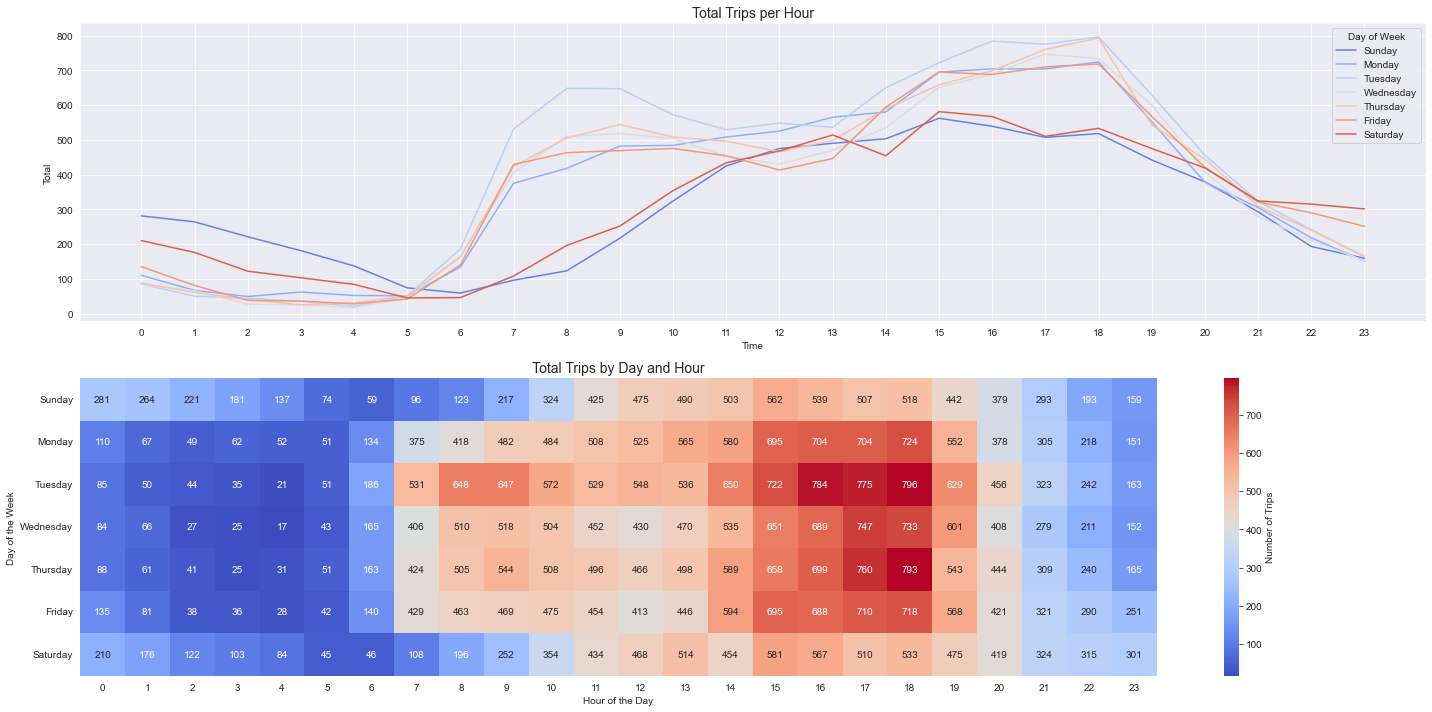

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `melted_cross` and `cross` are already defined
# Replace these with your actual data-loading code

# Example data for illustration purposes (replace with your actual dataset)
# melted_cross = pd.DataFrame({
#     'hour': np.tile(np.arange(24), 7),
#     'trips': np.random.randint(100, 500, 24 * 7),
#     'Day of Week': np.repeat(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 24)
# })
# cross = pd.DataFrame(np.random.randint(100, 500, (7, 24)),
#                      index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
#                      columns=np.arange(24))

# Determine unique values in 'Day of Week'
unique_days = melted_cross["Day of Week"].unique()
print("Unique days:", unique_days, "Count:", len(unique_days))

# Define color palette with the same number of colors as unique days
color = sns.color_palette("coolwarm", len(unique_days))

# Create the figure
plt.figure(figsize=(20, 10))

# Line plot (Total Trips per hour)
plt.subplot(2, 1, 1)
sns.lineplot(data=melted_cross, x="hour", y="trips", hue="Day of Week", palette=color)
plt.title("Total Trips per Hour", fontsize=14)
plt.xlabel("Time")
plt.xticks(np.arange(0, 24, 1))
plt.ylabel("Total")

# Heatmap (Total Trips by Day and Hour)
plt.subplot(2, 1, 2)
sns.heatmap(
    cross.iloc[:, :-1],
    cmap="coolwarm",
    annot=True,
    fmt="d",
    cbar_kws={"label": "Number of Trips"},
)
plt.title("Total Trips by Day and Hour", fontsize=14)
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

**Insights**

- There is a consistent increase in the morning, a relatively flat pattern during midday, followed by another increase in the afternoon.  
- Peak hours occur from Monday to Friday between 3:00 PM and 6:00 PM, with trips ranging from 650 to 796 throughout January.  
- On Tuesdays at 6:00 PM, the highest number of trips in January was recorded based on day and hour.  
- Meanwhile, the lowest number of trips occurred on Wednesdays at 4:00 AM, with only 17 trips.  

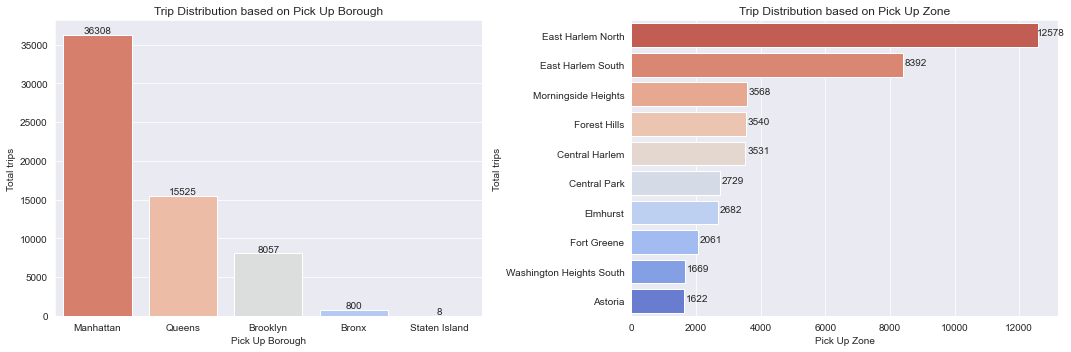

In [44]:
agg_borough = (
    df.groupby("PUBorough")
    .agg(count=("PUBorough", "count"))
    .sort_values(by="count", ascending=False)
    .reset_index()
)
agg_zone = (
    df.groupby("PUZone")
    .agg(count=("PUZone", "count"))
    .sort_values(by="count", ascending=False)
    .reset_index()
)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
bars = sns.barplot(x=agg_borough['PUBorough'], 
                   y=agg_borough['count'], 
                   palette=scale)
for idx, bar in enumerate(bars.patches):
    # Get X and Y placement of label from bar
    x_value = bar.get_x() + bar.get_width() / 2
    y_value = bar.get_height() + 200
    label = "{:.0f}".format(agg_borough['count'].iloc[idx]) 
    plt.text(x_value, y_value, label, ha='center')

plt.title('Trip Distribution based on Pick Up Borough')
plt.xlabel('Pick Up Borough')
plt.ylabel('Total trips')

plt.subplot(1,2,2)
bars = sns.barplot(data=agg_zone.head(10),
                   y='PUZone', 
                   x='count', 
                   palette=scale)
for idx, bar in enumerate(bars.patches):
    y_value = bar.get_y() + bar.get_height() / 2
    x_value = bar.get_width() + 400
    label = "{:.0f}".format(agg_zone['count'].iloc[idx]) 
    plt.text(x_value, y_value, label, ha='center')

plt.title('Trip Distribution based on Pick Up Zone')
plt.xlabel('Pick Up Zone')
plt.ylabel('Total trips')

plt.tight_layout()
plt.show()

**Insights**

- The highest demand for taxi trips occurred in Manhattan, with 36,000 trips, followed by Queens with 15,000, Brooklyn with 8,000, and Staten Island with the lowest demand of only 8 trips.  
- Meanwhile, the top 10 zones with the highest demand included East Harlem North with 12,000 trips, East Harlem South with 8,000, and Astoria with 1,622 trips.  

## Amount Distribution

In [45]:
import plotly.express as px

puzone_amount = df.groupby(['DOBorough', 'DOZone']).agg(trip_count=('fare_amount', 'count'), 
                                                        total_fare_amount=('fare_amount', 'sum'),
                                                        avg_fare_amount=('fare_amount', 'mean'),
                                                        median_fare_amount=('fare_amount', 'median')
                                                        ).sort_values(by='total_fare_amount', ascending=False).reset_index().round(2)

fig = px.treemap(puzone_amount, 
                 path=[px.Constant("All"), 'DOBorough', 'DOZone'], 
                 values='total_fare_amount', 
                 color='median_fare_amount',
                 color_continuous_scale='RdBu_r',
                 range_color=[5, 40],
                 custom_data=['trip_count', 'median_fare_amount'],
                 title='Heatmap for Average fare amount based on Drop off Location')
fig.update_traces(hovertemplate='<b>%{label}</b><br>Total Fare: %{value}<br>Trip Count: %{customdata[0]}<br>Median Fare: %{customdata[1]:.2f}')
fig.update_layout(margin = dict(t=50, l=0, r=0, b=0))
fig.update_traces(marker=dict(cornerradius=2))
fig.show()

In [46]:
trip_amount_dist = df.groupby(['PUZone', 'DOZone']).agg(trip_count=('PUZone', 'count'),
                                                        total_fare=('fare_amount', 'sum'), 
                                                        avg_fare=('fare_amount', 'mean'),
                                                        total_tip=('tip_amount', 'sum'), 
                                                        avg_tip=('tip_amount', 'mean')).reset_index().sort_values(by=['trip_count'], ascending=False).head(10).round(2)
route = trip_amount_dist['PUZone'] + " - " + trip_amount_dist['DOZone']
trip_amount_dist.insert(0, 'Route', route)
trip_amount_dist.drop(columns=['PUZone', 'DOZone'], inplace=True)

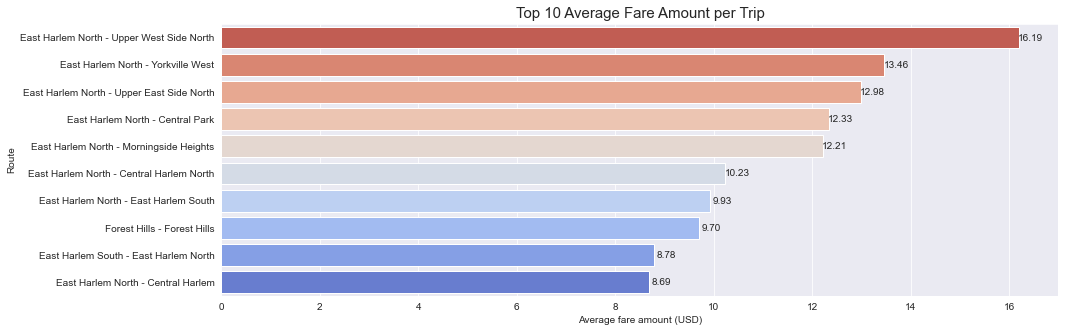

In [47]:
plt.figure(figsize=(15,5))
data = trip_amount_dist.sort_values(by='avg_fare', ascending=False)
bars = sns.barplot(data=data,
                   y='Route', 
                   x='avg_fare', 
                   palette=scale)
for idx, bar in enumerate(bars.patches):
    y_value = bar.get_y() + bar.get_height() / 1.6
    x_value = bar.get_width() + 0.25
    label = "{:.2f}".format(data['avg_fare'].iloc[idx]) 
    plt.text(x_value, y_value, label, ha='center')
plt.xlabel('Average fare amount (USD)')
plt.ylabel('Route')
plt.title('Top 10 Average Fare Amount per Trip', fontsize=15)

plt.show()

**Insights**  

- The top 10 routes with the highest average fare amounts based on the highest trip volumes include:  

  - East Harlem North - Upper West Side North: $16  
  - East Harlem North - Upper Yorkville West: $13  
  - East Harlem North - Upper East Side North: $12  
  - And lastly, East Harlem North - Central Harlem: $8.  

In [48]:
trip_data = pd.read_csv("data/train_data/train.csv")

In [49]:
# @title 2.1 - 🧼 Cleaning Up and Organizing Raw Data { form-width: "200px", display-mode: "form" }
def fancy_taxi_data(dataframe):

    # create a column for pickup year, pickup month, pickup day and a column for pick up time
    dataframe["pickup_year"] = pd.to_datetime(dataframe["pickup_datetime"]).dt.year
    dataframe["pickup_month"] = pd.to_datetime(dataframe["pickup_datetime"]).dt.month
    dataframe["pickup_day"] = pd.to_datetime(dataframe["pickup_datetime"]).dt.day
    dataframe["pickup_time"] = pd.to_datetime(dataframe["pickup_datetime"]).dt.time

    # create a column for drop-off year, pickup month, pickup day and a column for pick up time
    dataframe["dropoff_year"] = pd.to_datetime(dataframe["dropoff_datetime"]).dt.year
    dataframe["dropoff_month"] = pd.to_datetime(dataframe["dropoff_datetime"]).dt.month
    dataframe["dropoff_day"] = pd.to_datetime(dataframe["dropoff_datetime"]).dt.day
    dataframe["dropoff_time"] = pd.to_datetime(dataframe["dropoff_datetime"]).dt.time

    # Create a column for the day of the week for pickup and dropoff
    dataframe["pickup_day_of_week"] = pd.to_datetime(
        dataframe["pickup_datetime"]
    ).dt.day_name()
    dataframe["dropoff_day_of_week"] = pd.to_datetime(
        dataframe["dropoff_datetime"]
    ).dt.day_name()

    # Add a column with 1 if the day is weekday and 0 for weekend
    dataframe["is_weekday"] = dataframe["pickup_day_of_week"].apply(
        lambda x: 0 if x in ["Saturday", "Sunday"] else 1
    )

    # Add a column for the distance between the pickup and dropoff locations
    dataframe["distance_miles"] = (
        np.sqrt(
            (dataframe["pickup_latitude"] - dataframe["dropoff_latitude"]) ** 2
            + (dataframe["pickup_longitude"] - dataframe["dropoff_longitude"]) ** 2
        )
        * 69
    ).round(2)

    # Remove the pickup_datetime and dropoff_datetime columns as well as the vendor id and flag columns
    dataframe.drop(["pickup_datetime", "dropoff_datetime"], axis=1, inplace=True)
    dataframe.drop(["id", "vendor_id", "store_and_fwd_flag"], axis=1, inplace=True)

    return dataframe

In [50]:
trip_data = fancy_taxi_data(trip_data)

In [51]:
# @title 2.2.1 - ⏰ add_daytime_categories() { display-mode: "form" }
# @title  { display-mode: "form" }
def add_daytime_categories(dataframe):
    # Create a dictionary for different times of day
    daytime_categories = {
        "middle_of_night": ["00:00:00", "03:59:59"],
        "early_morning": ["04:00:00", "07:59:59"],
        "morning": ["08:00:00", "11:59:59"],
        "afternoon": ["12:00:00", "15:59:59"],
        "evening": ["16:00:00", "19:59:59"],
        "night": ["20:00:00", "23:59:59"],
    }

    # Convert daytime_categories to datetime objects
    for category, times in daytime_categories.items():
        daytime_categories[category] = [pd.to_datetime(time).time() for time in times]

    # Create a daytime_category column for pickup time
    def daytime_category(time):
        for category, times in daytime_categories.items():
            if times[0] <= time <= times[1]:
                return category

    # Apply the daytime_category function to the pickup_time column
    dataframe["pickup_daytime_category"] = dataframe["pickup_time"].apply(
        daytime_category
    )
    # Apply the daytime_category function to the dropoff_time column
    dataframe["dropoff_daytime_category"] = dataframe["dropoff_time"].apply(
        daytime_category
    )

    return dataframe

In [52]:
trip_data = add_daytime_categories(trip_data)

In [53]:
# Add a column with trip duration in minutes with two decimal places
trip_data["trip_duration_minutes"] = trip_data["trip_duration"].apply(
    lambda x: round(x / 60, 2)
)

In [54]:
trip_data.head(5)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_year,pickup_month,pickup_day,pickup_time,dropoff_year,dropoff_month,dropoff_day,dropoff_time,pickup_day_of_week,dropoff_day_of_week,is_weekday,distance_miles,pickup_daytime_category,dropoff_daytime_category,trip_duration_minutes
0,1,-73.982155,40.767937,-73.964630,40.765602,455,2016,3,14,17:24:55,2016,3,14,17:32:30,Monday,Monday,1,1.22,evening,evening,7.58
1,1,-73.980415,40.738564,-73.999481,40.731152,663,2016,6,12,00:43:35,2016,6,12,00:54:38,Sunday,Sunday,0,1.41,middle_of_night,middle_of_night,11.05
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016,1,19,11:35:24,2016,1,19,12:10:48,Tuesday,Tuesday,1,4.14,morning,afternoon,35.40
3,1,-74.010040,40.719971,-74.012268,40.706718,429,2016,4,6,19:32:31,2016,4,6,19:39:40,Wednesday,Wednesday,1,0.93,evening,evening,7.15
4,1,-73.973053,40.793209,-73.972923,40.782520,435,2016,3,26,13:30:55,2016,3,26,13:38:10,Saturday,Saturday,0,0.74,afternoon,afternoon,7.25


In [55]:
trip_data["miles_per_hour"] = trip_data["distance_miles"] / (
    trip_data["trip_duration_minutes"] / 60
)

In [56]:
# @title 3.9 - ➤ "taxi_pruned"  = removing the outliers as specified and reordering columns { display-mode: "form" }
# @title
def remove_outliers_fix_columns(dataframe):
    # Remove rows where the duration is greater than 5 hours and less than 1 minute
    dataframe = dataframe[
        (dataframe["trip_duration_minutes"] < 300)
        & (dataframe["trip_duration_minutes"] > 1)
    ]
    # Remove rows where the distance is greater than 100 miles and less than 0.1 miles
    dataframe = dataframe[
        (dataframe["distance_miles"] < 75) & (dataframe["distance_miles"] > 0.05)
    ]
    # Remove rows where the speed in miles per hour is greater than 100 mph
    dataframe = dataframe[
        (dataframe["miles_per_hour"] < 85) & (dataframe["miles_per_hour"] > 2)
    ]

    # Ordering the columns so that the new miles per hour column comes directly following the distance traveled
    column_order = [
        "trip_duration",
        "trip_duration_minutes",
        "duration_category",
        "distance_miles",
        "miles_per_hour",
        "is_weekday",
        "pickup_day_of_week",
        "pickup_daytime_category",
        "pickup_year",
        "pickup_month",
        "pickup_day",
        "pickup_time",
        "dropoff_day_of_week",
        "dropoff_daytime_category",
        "dropoff_year",
        "dropoff_month",
        "dropoff_day",
        "dropoff_time",
        "passenger_count",
        "pickup_longitude",
        "pickup_latitude",
        "dropoff_longitude",
        "dropoff_latitude",
    ]
    dataframe = dataframe.reindex(columns=column_order)

    # Shortening the column names so that we can see more when we display parts of our data
    dataframe.rename(
        columns={
            "trip_duration": "dur_sec",
            "trip_duration_minutes": "dur_min",
            "duration_category": "dur_cat",
            "distance_miles": "dis_mi",
            "miles_per_hour": "mph",
            "is_weekday": "is_wkdy",
            "pickup_day_of_week": "pu_dow",
            "pickup_daytime_category": "pu_dtc",
            "pickup_year": "pu_yr",
            "pickup_month": "pu_mo",
            "pickup_day": "pu_dy",
            "pickup_time": "pu_tm",
            "dropoff_day_of_week": "do_dow",
            "dropoff_daytime_category": "do_dtc",
            "dropoff_year": "do_yr",
            "dropoff_month": "do_mo",
            "dropoff_day": "do_dy",
            "dropoff_time": "do_tm",
            "passenger_count": "pass_cnt",
            "pickup_longitude": "pu_lon",
            "pickup_latitude": "pu_lat",
            "dropoff_longitude": "do_lon",
            "dropoff_latitude": "do_lat",
        },
        inplace=True,
    )
    return dataframe

In [57]:
trip_data = remove_outliers_fix_columns(trip_data)

In [58]:
# @title 3.11 - 🗺 GEO-MAPPING { display-mode: "form" }
routes_sample = trip_data.sample(80)
routes_df = gpd.GeoDataFrame(
    routes_sample,
    geometry=gpd.points_from_xy(routes_sample.pu_lon, routes_sample.pu_lat),
)
# Plot 80 routes on the map
fig = px.scatter_mapbox(
    routes_df,
    lat="pu_lat",
    lon="pu_lon",
    zoom=12,
    width=800,
    height=500,
    color_continuous_scale=px.colors.cyclical.IceFire,
    mapbox_style="open-street-map",
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(hoverlabel=dict(bgcolor="#444444", font_size=12, font_color="white"))
fig.add_trace(
    go.Scattermapbox(
        mode="lines",
        lon=routes_df["pu_lon"],
        lat=routes_df["pu_lat"],
        marker={"size": 15},
        line=dict(width=2, color="purple"),
        text=routes_df["pu_lon"],
        opacity=0.5,
        showlegend=False,
        customdata=np.stack(
            (routes_df["dis_mi"], routes_df["dur_min"], routes_df["pu_dtc"]), axis=-1
        ),
    )
)
fig.update_traces(
    hovertemplate=(
        "<br><b>Distance</b>: %{customdata[0]: .2f} miles<br>"
        + "<br><b>Duration </b>: %{customdata[1]: .2f} min<br>"
        + "<br><b>Time </b>: %{customdata[2]}<br>"
    )
)
fig.show()

## Streamlit App

In [59]:
import streamlit as st
import pandas as pd
import altair as alt
import plotly.express as px

In [60]:
st.set_page_config(
    page_title="NYC Taxi Data Analysis",
    page_icon="🏂",
    layout="wide",
    initial_sidebar_state="expanded",
)

alt.themes.enable("dark")

ThemeRegistry.enable('dark')

In [61]:
col = st.columns((1.5, 4.5, 2))

In [62]:
with col[0]: 
    st.markdown("#### Interactive Route Map")
    st.plotly_chart(fig, use_container_width=True)

2024-11-23 23:00:04.115 
  command:

    streamlit run c:\Python39\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [63]:
with col[1]:
    st.markdown("#### Interactive Route Map")
    st.plotly_chart(fig, use_container_width=True)

In [64]:
with col[2]:
    st.markdown("#### Interactive Route Map")
    st.plotly_chart(fig, use_container_width=True)